# Exam version A

Please read the exercices carefully, write the necesary code and respond to all the questions.


The following two cells load the images used in the exam and the filter bank.

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import LM_filters
import matplotlib.pyplot as plt


path = "./images/texturesimages/buildings/"
buildings = []
for i in range(1,31):
    image = "buildings_" + str(i) + ".jpg"
    buildings.append(skimage.io.imread(path + image))
    
path = "./images/texturesimages/sunset/"
sunsets = []
for i in range(1,31):
    image = "sunset_" + str(i) + ".jpg"
    sunsets.append(skimage.io.imread(path + image))    
    
all_images = buildings + sunsets
filter_bank = LM_filters.makeLMfilters()


LM filters imported, the shape of the filter bank is:  (49, 49, 48)


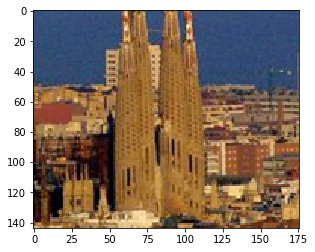

In [2]:
query = skimage.img_as_float(skimage.io.imread("./images/query_a.jpg"))
plt.imshow(query)

##   lm feature vectors

Given **`n_filters`** filters from a filter bank and a single image **`grayscale_image`**, we provide a function **`features_from_filter_bank(grayscale_image, filter_bank)`** that takes as input

- `grayscale_image`: a 2D numpy array (containing a grayscale image).
- `filter_bank`: a 3D numpy array (containing the lm filters).

The function returns a numpy array  (feature vector of shape equal to the number of filters in `filter_bank`). The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$. That is

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_{\text{n_filters}}|) \right)
$$

#### Do/Answer the following 

- Apply this function to **`query`** and save the result in **`query_lm`**. Recall to transform the image to gray using `skimage.color.rgb2gray`.
- How many elements **`query_lm`** has ?

In [3]:
%%time

def features_from_filter_bank(grayscale_image, filter_bank):
    im_conv = np.zeros(grayscale_image.shape)
    n_filters = filter_bank.shape[-1]
    features_for_im = np.zeros(n_filters)
    
    for i in range(n_filters):
        scipy.ndimage.convolve(grayscale_image, filter_bank[:,:,i], output=im_conv)
        features_for_im[i] = np.mean(np.abs(im_conv))

    return features_for_im

grayscale_query = skimage.color.rgb2gray(query)
query_lm = features_from_filter_bank(grayscale_query, filter_bank)

Wall time: 4.94 s


In [4]:
grayscale_query = skimage.color.rgb2gray(query)
query_lm = features_from_filter_bank(grayscale_query, filter_bank)

In [5]:
query_lm.shape[0]

48


Use the provided function **`generate_X_lm(all_images,  filter_bank)`** that returns a **numpy array** which contains at row `n` the lm features of `all_images[n]`.

- Use the function to generate `X_lm = generate_X(all_images,  filter_bank)`.


In [8]:
def generate_X_lm(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    
    X=np.zeros((n_images, filter_bank.shape[-1]))
    t0 = time.time()
    for k,image in enumerate(all_images):
        
        print('processing image ',k, end="\r")

        # Get black and white image
        image_gray = skimage.color.rgb2gray(all_images[k])

        # Get the feature vector for the current image
        X[k] = features_from_filter_bank(image_gray, filter_bank)
        
    X = np.array(X)
    return X

In [9]:
%%time
X_lm = generate_X_lm(all_images,  filter_bank)

Wall time: 4min 32s9


In [10]:
X_lm.shape

(60, 48)

### Exercise 1.1 [3 points]


Create a function **`retrieve_k_ind_and_dist_from_X(query_feat, X, k)`** that takes as input:

- **`query_feat`**: A numpy array (with `n_features` elements). 
- **`X`**: A numpy array of shape `(n_samples, n_features)` containing at row `j` the features of image `j`.
- **`k`**: An integer stating the number of  indices (and distances) to return.

The function has to
- compute the distance (euclidean distance) between `query_feat` and all rows of `X`. 
- retrieve the `k` smalest distances (from  the previously computed distances) 
- retrieve the `k` indices of the rows that achieved the lowest distance.

The function MUST return two `np.ndarray` objects of length `k` which have to be named  `k_closest_image_ind`and ` k_closest_image_dist`.

- **`k_closest_image_ind`** has to contain the indices of the k closest rows of X to query.
- **`k_closest_image_dist`** has to contain the distances of the k closest rows of X to query.


#### Respond the following 

Use the function to find out the 4 rows of X that are the most similar to the given **`query`**. That is compute

```k_closest_image_ind, k_closest_image_dist = retrieve_k_images_from_X(query_lm, X_lm, 4)```

- Print the indices and the distances in  a cell in the following way

```
print("indices:", k_closest_image_ind)
print("distances:", k_closest_image_dist)
```


In [98]:
def retrieve_k_ind_and_dist_from_X(query_feat, X, k):
    distances = []
    k_closest_image_dist = None
    k_closest_image_ind =[]
    
    for i in X: # for each image
        distances.append(np.linalg.norm(query_feat-i)) # we calculate the distance with the query
    k_closest_image_dist = sorted(distances) # we get the distances sorted
    k_closest_image_dist = k_closest_image_dist[:k] # and we reduce the size of the vector to k
    
    
    for j in k_closest_image_dist: # for each value in k_closest_image_dist
        for y in range(len(distances)): # for each distance
            if j-distances[y] == 0: # if we found the "image"
                k_closest_image_ind.append(y) # we save its position in the database
    return k_closest_image_ind, k_closest_image_dist
    

In [99]:
k_closest_image_ind, k_closest_image_dist = retrieve_k_ind_and_dist_from_X(query_lm, X_lm, 4)
print("indices:", k_closest_image_ind)
print("distances:", k_closest_image_dist)

indices: [44, 58, 46, 52]
distances: [0.011910467702992231, 0.059748910237354, 0.074838587102108931, 0.18807553822217768]


### Exercise 1.2 [1.5 points]

Create a function `print_closest_k_images_to_query(query, images, k_closest_image_ind,  k_closest_image_dist)` that takes as input:

- **`query`**: an 3D array containing the query image.
- **`images`**: A list of 3D arrays containing several images.
- **`k_closest_image_ind`**: as explained in the previous exercise.
- **`k_closest_image_dist`**: as explained in the previous exercise.

This function has to:

- Generate a plot (in a single row) showing the query followed by the k closest images to the query. Images have to be sorted by proximity.
   - The plot has to contain the distances from the query to the shown image at the top of the image. Print at most 4 digits containing the distance (if a distance is 1.23123123123 print only 1.231).
- Save the plot in a file called **`closest_to_query.jpg`**. Recall that to save a plot you can use `plt.savefig("closest_to_query.jpg")`.



To sum up, the function `print_closest_k_images_to_query` has to generate a plot with the same style as the figure below:

![title](images/closest_to_image0.jpg)

#### Call the function and add the generated pdf in the exam
```
print_closest_k_images_to_query(query, all_images, k_closest_image_ind, k_closest_image_dist)
```


In [100]:
def print_closest_k_images_to_query(query, images, k_closest_image_ind,  k_closest_image_dist):
    
    fig, axarr = plt.subplots(1,5)
    fig.set_size_inches(10,5)
    
    
    axarr[0].imshow(images[k_closest_image_ind[0]],cmap='gray')
    axarr[0].set_title('Query')
    axarr[0].xaxis.set_visible(False)
    axarr[0].yaxis.set_visible(False)
    
    
    axarr[1].imshow(images[k_closest_image_ind[0]], cmap='gray')
    axarr[1].set_title('Dist: %s' %(round(k_closest_image_dist[0], 3)))
    axarr[1].xaxis.set_visible(False)
    axarr[1].yaxis.set_visible(False)
    
    axarr[2].imshow(images[k_closest_image_ind[1]], cmap='gray')
    axarr[2].set_title('Dist: %s' %(round(k_closest_image_dist[1], 3)))
    axarr[2].xaxis.set_visible(False)
    axarr[2].yaxis.set_visible(False)
    
    axarr[3].imshow(images[k_closest_image_ind[2]], cmap='gray')
    axarr[3].set_title('Dist: %s' %(round(k_closest_image_dist[2], 3)))
    axarr[3].xaxis.set_visible(False)
    axarr[3].yaxis.set_visible(False)
    
    axarr[4].imshow(images[k_closest_image_ind[3]], cmap='gray')
    axarr[4].set_title('Dist: %s' %(round(k_closest_image_dist[3], 3)))
    axarr[4].xaxis.set_visible(False)
    axarr[4].yaxis.set_visible(False)
    plt.savefig("closest_to_query.jpg")
    plt.show()

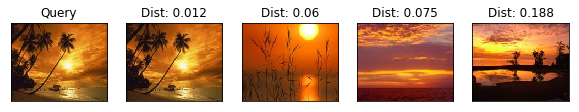

In [101]:
print_closest_k_images_to_query(query, all_images, k_closest_image_ind,  k_closest_image_dist)

## Ex 1.3 [1.5 points]

Find the closest image to the query. Given the closest query find the 5 features that match the most between the query and the most similar image. Let us call this features f1,...,f5. 

Now retrieve again the 4 most similar images from the query to X but instead of using all the features in `X_lm` use only f1,...,f5.

- Print the indices of the closest images using f1,...,f5 (to compute the distances).
- Print the distances between que query and the other images using f1,...,f5 (to compute the distances).
- Make the same plot as in 1.4 using the new distances and closest images.

In [90]:
def un_test(query_feat, X, k):
    distances = []
    k_closest_image_dist = None
    k_closest_image_ind =[]
    
    for i in X: # for each image
        distances.append(np.linalg.norm(query_feat-i)) # we calculate the distance with the query
    k_closest_image_dist = sorted(distances) # we get the distances sorted
    
    for y in range(len(distances)): # for each distance
        if k_closest_image_dist[0]-distances[y] == 0: # if we found the "image"
            k_closest_image_ind.append(y) # we save its position in the database
            our_x = X[y] # we save the x index
            our_x_index = y
            
    x_distances = []
    closest_x = None
    
    for i in our_x:
        x_distances.append(np.linalg.norm(query_feat-i)) # we calculate the distance with the query
    closest_x = sorted(x_distances)
    closest_x = closest_x[:k] # we save the closest features


    closest_in_x_ind = []
    for i in closest_x: # for each value in closest_x
        for j in range(len(x_distances)): # for each distance
            if i-x_distances[j] == 0 and j not in closest_in_x_ind: # if we found the "x"
                closest_in_x_ind.append(j) # we save its position in the database
    return our_x_index, closest_in_x_ind

un_test(query_lm, X_lm, 5)

(44, [41, 42, 44, 43, 45])

In [91]:
def ex_13(query_lm, X_lm, k):
    x_ind, feat_ind = un_test(query_lm, X_lm, 5)
    
    distances = []
    k_closest_image_dist = None
    k_closest_image_ind =[]
    
    for i in feat_ind: # for each image        
        distances.append(np.linalg.norm(query_lm-X_lm[x_ind][i])) # we calculate the distance with the query
    k_closest_image_dist = sorted(distances) # we get the distances sorted
    k_closest_image_dist = k_closest_image_dist[:k] # and we reduce the size of the vector to k
    
    # now we look for the image that's in the k_closest_image_dist vector
    for j in k_closest_image_dist: # for each value in k_closest_image_dist
        for y in range(len(distances)): # for each distance
            if j-distances[y] == 0 and y not in k_closest_image_ind: # if we found the "image"
                k_closest_image_ind.append(y) # we save its position in the database
    return k_closest_image_ind, k_closest_image_dist
    closest_image = all_images[k_closest_image_ind[0]] 

indices: [0, 1, 2, 3]
distances: [7.0180955536900473, 7.0487377244893921, 7.0487377244893921, 7.0954749254978111]


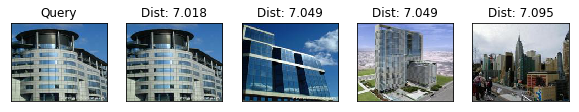

In [92]:
k_closest_image_ind, k_closest_image_dist = ex_13(query_lm, X_lm, 4)
print("indices:", k_closest_image_ind)
print("distances:", k_closest_image_dist)
print_closest_k_images_to_query(query, all_images, k_closest_image_ind,  k_closest_image_dist)

## Ex 1.4 [1.5 points]

Create a function `match_cross_correlation(image, template)` that uses the normalized cross-correlation to apply template matching and takes as input:

- **`image`**: a 3D array containing the reference image.
- **`template`**: a 3D array containing the template that will be matched to the reference.

The function must return:

- **`im_result_correlation`**: an image with the result of the template matching stored in each pixel.


In [93]:
from skimage.feature import match_template
from skimage.color import rgb2gray

def match_cross_correlation(image, template):
    im_result_correlation = match_template(rgb2gray(image),rgb2gray(template))# we transform the images to gray and
    # we get the normalized cross correlation image
    return im_result_correlation

## Ex 1.5 [2.5 points]

Create a function `visualize_matching(image, template, im_result_correlation, thres_cross_correl)` for visualizing the result of the template matching. It must that takes as inputs:

- **`image`**: a 3D array containing the reference image.
- **`template`**: a 3D array containing the template that will be matched to the reference.
- **`im_result_correlation`**: an image with the result of the template matching stored in each pixel.
- **`thres_cross_correl`**: threshold for detecting high responses in the normalized cross-correlation matching.

The function should obtain and plot a result similar to this:

![title](images/matching_example.png)

**Note: do not forget to put titles on the figures shown!**

Given the image `animales.jpg` and the template image `paloma_template.jpg`, detect the location of the template in the image be following these steps:

- Use `match_cross_correlation()`.
- Visualize the result of the template matching with `visualize_matching()` and find the most suitable threshold.
- Comment the result obtained.

**Note: do not forget to convert the images to grayscale.**

In [94]:
def visualize_matching(image, template, im_result_correlation, thres_cross_correl):
    image = rgb2gray(image)
    # we binarize the resultof the X-correlation to find the positions where the template is located
    image_bin=np.zeros([image.shape[0],image.shape[1]])
    # we save the maximum value of the image, this value will correspond to the zone with more proximity to the template
    valor =im_result_correlation.max()
    # then we set the bin image values to 1, using a threshold to show the corresponding pixels of the template
    image_bin[image <= valor-thres_cross_correl] = 255
    fig, axarr = plt.subplots(2,2)
    fig.set_size_inches(10,15)

    #imatge
    axarr[0][0].imshow(given_image,cmap='gray')
    axarr[0][0].set_title('Image')
    axarr[0][0].xaxis.set_visible(False)
    axarr[0][0].yaxis.set_visible(False)

    #imatge després
    axarr[0][1].imshow(im_result_correlation, cmap='gray')
    axarr[0][1].set_title('Norm. Cross-correlation matching')
    axarr[0][1].xaxis.set_visible(False)
    axarr[0][1].yaxis.set_visible(False)

    axarr[1][0].imshow(template, cmap='gray')
    axarr[1][0].set_title('Template')
    axarr[1][0].xaxis.set_visible(False)
    axarr[1][0].yaxis.set_visible(False)

    axarr[1][1].imshow(image_bin, cmap='gray')
    axarr[1][1].set_title('Norm. cross-correlation thresholded')
    axarr[1][1].xaxis.set_visible(False)
    axarr[1][1].yaxis.set_visible(False)

    plt.show()

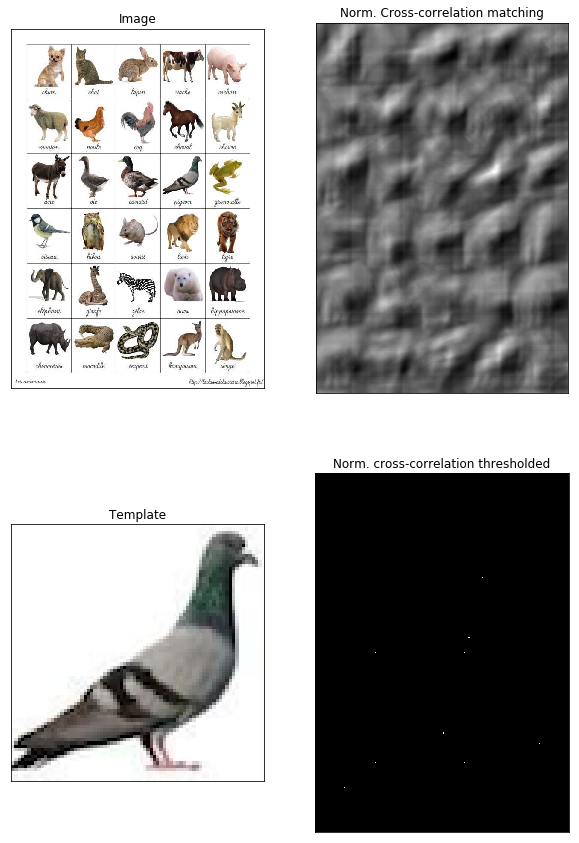

In [95]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage import data, io, img_as_float


%matplotlib inline

# Load images
template=io.imread('./images/paloma_template.jpg')
given_image=io.imread('./images/animals.jpg')


im_result_correlation = match_cross_correlation(given_image, template)

visualize_matching(given_image, template, im_result_correlation, 0.7389)


Com a valor de threshold he agafat un valor molt proper al valor del pixel amb més intensitat de la imatge(alla és on hi haurà la major semblança, i com es pot veure en el plot, hi ha diferents punts trobats.
Tot i així, la zona on realment està situat el colom del nostre template en la imatge original, és el punt on hi ha més quantitat de pixels un cop fet el threshold.
Ara podriem calcular la zona amb més àrea o buscar el punt de valor màxim de la imatge per tal de trobar la posició exacta del nostre template.
